In [132]:
from pathlib import Path
import torch
from datasets import load_dataset
from transformers import RobertaTokenizer
from transformers import RobertaForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score

DATA_SET_PATH = "D:\code\pytorch\llm_secret\ces\data\engBinary_parsed.json"
CACHE_DIR = Path("cache-dir/")

In [133]:
!where python

D:\code\pytorch\venv\Scripts\python.exe
C:\Users\simon\AppData\Local\Microsoft\WindowsApps\python.exe


In [134]:
def loading_data():
    print("Start Loading Data")

    dataset = load_dataset("json", data_files=str(DATA_SET_PATH), cache_dir=CACHE_DIR)

    # Split the dataset
    dataset = dataset["train"].train_test_split(test_size=0.2)
    train_dataset = dataset["train"]
    test_dataset = dataset["test"].shard(num_shards=2, index=0)
    val_dataset = dataset["test"].shard(num_shards=2, index=1)

    print("Finished Loading Data")
    return train_dataset, val_dataset, test_dataset
    

In [135]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base", max_len=512)
enc_input = tokenizer("This is an example sentence.", return_tensors="pt")

model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=7, problem_type="multi_label_classification")
output = model(**enc_input)
print(output.logits)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor([[-0.0431, -0.0376, -0.0775, -0.2729,  0.0287,  0.0507,  0.0562]],
       grad_fn=<AddmmBackward0>)


In [136]:
def encode(batch):
    return tokenizer(batch['sentence'], padding="max_length", truncation=True, max_length=512)

def get_label_list(example):
    label_mapping = {"joy":0, "sadness":1, "fear":2, "anger":3, "surprise":4, "disgust":5, "none":6}
    emotion_label_list = [0.0,0.0,0.0,0.0,0.0,0.0,0.0]
    for emotion in example['emotions']:
        emotion_label_list[label_mapping[emotion]] = 1
    return emotion_label_list

def add_labels(example):
    example["label"] = get_label_list(example)
    return example

def tokenize_data(train_dataset, val_dataset, test_dataset):
    # tokenizer = RobertaTokenizer.from_pretrained("roberta-base", max_len=512)
    tokenized_train_dataset = train_dataset.map(encode)
    tokenized_train_dataset = tokenized_train_dataset.map(add_labels)
    
    tokenized_val_dataset = val_dataset.map(encode)
    tokenized_val_dataset = tokenized_val_dataset.map(add_labels)
    
    tokenized_test_dataset = test_dataset.map(encode)
    tokenized_test_dataset = tokenized_test_dataset.map(add_labels)
    
    return tokenized_train_dataset, tokenized_val_dataset, tokenized_test_dataset

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

In [137]:
train_dataset, val_dataset, test_dataset = loading_data()
tokenized_train_dataset, tokenized_val_dataset, tokenized_test_dataset = tokenize_data(train_dataset, val_dataset, test_dataset)

Start Loading Data
Finished Loading Data


In [138]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Device: ", device)

Device:  cuda


In [139]:
training_args = TrainingArguments(
    output_dir="roberta-for-classification",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=15,
    weight_decay=0.01
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
trainer.train()
trainer.save_model("roberta-for-classification")

C:\Users\simon\AppData\Local\Temp\ipykernel_22684\3608995469.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.356400
1000,0.207700
1500,0.136500
2000,0.101400


In [140]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # logits.to(device)
    predictions = (torch.sigmoid(torch.tensor(logits)) > 0.5).int()
    accuracy = accuracy_score(labels, predictions.numpy())
    f1 = f1_score(labels, predictions.numpy(), average='weighted')
    return {
        "accuracy": accuracy,
        "f1": f1
    }

In [141]:
model.to(device)
# Define the trainer
trainer_val = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics
)

# Evaluate on validation and test datasets
val_results = trainer_val.evaluate(tokenized_val_dataset)
test_results = trainer_val.evaluate(tokenized_test_dataset)

# Print the results
print("Validation Results:", val_results)
print("Test Results:", test_results)

D:\code\pytorch\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Results: {'eval_loss': 0.3547474443912506, 'eval_model_preparation_time': 0.0025, 'eval_accuracy': 0.4332129963898917, 'eval_f1': 0.7007526361470158, 'eval_runtime': 11.0684, 'eval_samples_per_second': 25.026, 'eval_steps_per_second': 1.626}
Test Results: {'eval_loss': 0.2887216806411743, 'eval_model_preparation_time': 0.0025, 'eval_accuracy': 0.5090252707581228, 'eval_f1': 0.7567194068712416, 'eval_runtime': 8.6183, 'eval_samples_per_second': 32.141, 'eval_steps_per_second': 2.089}


D:\code\pytorch\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### LR LOG
- with lr = 2*e-4 (15eps)
    - Validation Results: {'eval_loss': 0.46101173758506775, 'eval_model_preparation_time': 0.002, 'eval_accuracy': 0.4187725631768953, 'eval_f1': 0.6940540982612379, 'eval_runtime': 4.891, 'eval_samples_per_second': 56.635, 'eval_steps_per_second': 3.68}
    - Test Results: {'eval_loss': 0.37369832396507263, 'eval_model_preparation_time': 0.002, 'eval_accuracy': 0.516245487364621, 'eval_f1': 0.750948861078814, 'eval_runtime': 4.6137, 'eval_samples_per_second': 60.039, 'eval_steps_per_second': 3.901}
- with lr = 1*e-4 (15eps)
    - Validation Results: {'eval_loss': 0.3547474443912506, 'eval_model_preparation_time': 0.0025, =='eval_accuracy': 0.4332129963898917, 'eval_f1': 0.7007526361470158==, 'eval_runtime': 11.0684, 'eval_samples_per_second': 25.026, 'eval_steps_per_second': 1.626}
    - Test Results: {'eval_loss': 0.2887216806411743, 'eval_model_preparation_time': 0.0025, 'eval_accuracy': 0.5090252707581228, 'eval_f1': 0.7567194068712416, 'eval_runtime': 8.6183, 'eval_samples_per_second': 32.141, 'eval_steps_per_second': 2.089}

In [142]:
enc_input = tokenizer("Today my teacher said something nice about my looks.", return_tensors="pt").to(device)
output = model(**enc_input)
print(output.logits)

tensor([[ 3.6159, -3.5054, -3.1581, -3.1239, -2.7003, -3.5436, -3.7150]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


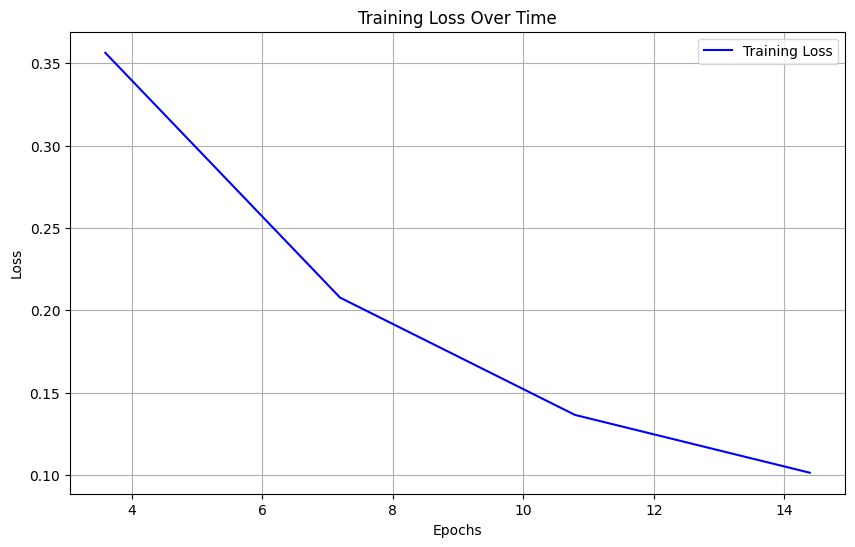

In [148]:
import matplotlib.pyplot as plt

train_logs = trainer.state.log_history

# Extract the training loss and epoch information (or any other metric)
losses = [log['loss'] for log in train_logs if 'loss' in log]
epochs = [log['epoch'] for log in train_logs if 'loss' in log]

# Plot the loss over time
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, label="Training Loss", color='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()